<a href="https://colab.research.google.com/github/Jayfaldu/ML_Notebooks/blob/master/Skin_cancer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skin Cancer Segmentation using DeepLab

I've programmed the model architecture from scratch in PyTorch. To hasten the training, weights from the first few layers of ResNet are transfered to this ResNet module.

In [0]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
data_path='/content/drive/My Drive/DATA/DATA/'

## Load Pickled Data
We've rescaled the image data to the range [0.0, 1.0] and stored as a pickle for fast loading

In [0]:
train_img_x,train_img_y,val_img_x,val_img_y=pickle.load(open('/content/drive/My Drive/DATA/cancer_rescaled.pkl',mode='rb'))
test_img_x, test_img_y = pickle.load(open('/content/drive/My Drive/DATA/test.pkl', mode='rb'))

print(train_img_x.max(), val_img_x.max(), test_img_x.max())
print(train_img_x.min(), val_img_x.min(), test_img_x.min())

tensor(1.) tensor(1.) tensor(1.)
tensor(0.) tensor(0.) tensor(0.)


## Model Construction

In [0]:
class Resnet(nn.Module):
    #Very small version of ResNet
  
  def __init__(self):
    super().__init__()
    self.a1=nn.Sequential(self.layer(3,64),
                          nn.ReLU())
    self.bottle1=self.BottleNeck(64)
    self.a2=nn.Sequential(self.layer(64,128,ksize=(3,3),stride=2),
                          nn.ReLU())
    self.bottle2=self.BottleNeck(128)
    self.a3=nn.Sequential(self.layer(128,256,ksize=(3,3),stride=2),
                          nn.ReLU())
    self.bottle3=self.BottleNeck(256)
    self.a4=nn.Sequential(self.layer(256,512,ksize=(3,3),stride=2),
                          nn.ReLU())
    
  def conv(self,in_chan,out_chan,ksize=(3,3),stride=1,pad=1):
    return nn.Conv2d(in_chan,out_chan,kernel_size=ksize,stride=stride,padding=pad)  
    
  def layer(self,in_chan,out_chan,stride=1,ksize=(3,3),pad=1):
    return nn.Sequential(self.conv(in_chan,out_chan,ksize,stride,pad),
                         nn.BatchNorm2d(out_chan))

  def BottleNeck(self,in_chan):
    return nn.Sequential(self.layer(in_chan,in_chan//2,ksize=(1,1),pad=0),
                  self.layer(in_chan//2,in_chan//2),
                  self.layer(in_chan//2,in_chan,ksize=(1,1),pad=0),
                  nn.ReLU())

  def forward(self,x):
    x = self.a1(x)
    x = x + self.bottle1(x)
    x = self.a2(x)
    small = x
    x = x + self.bottle2(x)
    x = self.a3(x)
    x = x + self.bottle3(x)
    x = self.a4(x)
    
    return x,small
    

In [0]:
class aspp(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.inplane=512
    self.aspp_outchannels = 128
    self.overall_outchannels = 256
    #dilations of [1, 6, 12, 18] is too big for our resnet features which are around 22×32
    self.dilation=[1,3,6,9]
    self.aspp1=self.aspp_layer(self.inplane, self.aspp_outchannels,(1,1),self.dilation[0],pad=0)
    self.aspp2=self.aspp_layer(self.inplane, self.aspp_outchannels,(3,3),self.dilation[1],pad=self.dilation[1])
    self.aspp3=self.aspp_layer(self.inplane, self.aspp_outchannels,(3,3),self.dilation[2],pad=self.dilation[2])
    self.aspp4=self.aspp_layer(self.inplane, self.aspp_outchannels,(3,3),self.dilation[3],pad=self.dilation[3])
    
    self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(self.inplane, self.aspp_outchannels, (1,1), stride=1, bias=False),
    #TODO: HOW TO MAKE THIS WORK?
                                            #  nn.BatchNorm2d(self.aspp_outchannels),
                                             nn.ReLU())
    
    self.conv1 = nn.Conv2d(5 * self.aspp_outchannels, self.overall_outchannels, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(self.overall_outchannels)
    self.relu = nn.ReLU()
    
  def aspp_layer(self,in_chan,out_chan,ksize,dilation,pad):
    return nn.Sequential(nn.Conv2d(in_chan,out_chan,kernel_size=ksize,padding=pad,dilation=dilation),
                         nn.BatchNorm2d(out_chan),
                         nn.ReLU())
  
  def forward(self,x):
    x1=self.aspp1(x)
    x2=self.aspp2(x)
    x3=self.aspp3(x)
    x4=self.aspp4(x)
    x5=self.global_avg_pool(x)
    x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
    x = torch.cat((x1, x2, x3, x4,x5), dim=1)

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    
    return x
    
  

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.early_features_inchannels = 128

        self.early_features_conv = nn.Sequential(
            nn.Conv2d(self.early_features_inchannels, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

        #TODO: Should we add SKIP CONNECTIONS in this conv block as well?
        
        self.last_conv = nn.Sequential(
            nn.Conv2d(256 + 48, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, num_classes, kernel_size=1, stride=1, padding=0, bias=False)
        )

    def forward(self, xb, early_features):
        features = self.early_features_conv(early_features)

        xb = F.interpolate(xb, features.shape[2:], mode='bilinear', align_corners=True)
        xb = torch.cat((xb, features), dim=1)

        return self.last_conv(xb)

In [0]:
class DeepLab(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.num_classes = num_classes

        self.resnet = Resnet().to(device)
        self.aspp = aspp().to(device)
        self.decoder = Decoder(num_classes=num_classes).to(device)

    def forward(self, xb):
        x, early_features = self.resnet(xb)
        x = self.aspp(x)
        x = self.decoder(x, early_features)

        return F.interpolate(x, xb.shape[2:], mode='bilinear', align_corners=True)

In [0]:
x = torch.randn(10,3,192,256).to(device)

In [0]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias, mean=0.0, std=0.01)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

def get_deeplab(num_classes):
    model = DeepLab(num_classes=num_classes).to(device)
    
    # model.apply(weights_init)

    return model

### This Deeplab Model has ~4.41 Million Parameters

In [0]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
deeplab = get_deeplab(1)

In [0]:
count_params(deeplab)

4406112

In [0]:
bce_loss = torch.nn.BCEWithLogitsLoss()

In [0]:
import random

def get_batches(bs):
    idxs = np.random.permutation(len(train_img_x))

    for i in tqdm(range(0, len(idxs) - bs + 1, bs)):
        res_x, res_y = train_img_x[ idxs[i:i+bs] ].clone(), train_img_y[ idxs[i:i+bs] ].clone()

        #randomly choose between 4 options:
        c = random.randint(0, 3)

        if c == 0:
            #leave image as is
            yield res_x, res_y
        elif c == 1:
            #flip sideways
            yield res_x.flip(2), res_y.flip(1)
        elif c == 2:
            #flip upwards
            yield res_x.flip(3), res_y.flip(2)
        elif c == 3:
            #flip both sideways and upwards. In effect, do a 180° turn
            yield res_x.flip(3).flip(2), res_y.flip(2).flip(1)

def get_batches_small(bs):
    #for quick LR-Find
    idxs = np.random.permutation(300)

    for i in tqdm(range(0, len(idxs) - bs + 1, bs)):
        yield train_img_x[ idxs[i:i+bs] ], train_img_y[ idxs[i:i+bs] ]

In [0]:
def get_val_loss_accuracy(model, device='cuda'):
    model.eval()
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(zip(val_img_x, val_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = IoU_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

def IoU_accuracy(y_preds, y_real, t=0.5, plot=False):
    '''Intersection over Union metric'''
    # print(y_preds.dtype, y_preds.shape)
    # print(tmp.dtype)
    thres = (y_preds > t).type(torch.ByteTensor)
    realz = y_real.type(torch.ByteTensor)

    intersect = (thres & realz).sum().float() 
    union = (thres | realz).sum().float()
    result = intersect / union
    # print(intersect, union, res)

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 2, 1)
        plt.imshow(thres)
        plt.subplot(3, 2, 2)
        plt.imshow(realz)

        plt.subplot(3, 2, 3)
        plt.imshow(thres & realz)
        plt.subplot(3, 2, 4)
        plt.imshow(thres | realz)

        plt.subplot(3, 2, 5)
        plt.imshow(y_preds)
        plt.subplot(3, 2, 6)
        plt.imshow(y_real)

    return result.item()

def Dice_accuracy(y_preds, y_real, t=0.5, plot=False):
    '''2 * Intersection / (real.sum() + prediction.sum())'''
    # print(y_preds.dtype, y_preds.shape)
    # print(tmp.dtype)
    thres = (y_preds > t).type(torch.ByteTensor)
    realz = y_real.type(torch.ByteTensor)

    intersect = (thres & realz).sum().float() 
    union = (thres | realz).sum().float() 
    result = (intersect + intersect) / (union + intersect)
    # print(intersect, union, res)

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 2, 1)
        plt.imshow(thres)
        plt.subplot(3, 2, 2)
        plt.imshow(realz)

        plt.subplot(3, 2, 3)
        plt.imshow(thres & realz)
        plt.subplot(3, 2, 4)
        plt.imshow(thres | realz)

        plt.subplot(3, 2, 5)
        plt.imshow(y_preds)
        plt.subplot(3, 2, 6)
        plt.imshow(y_real)

    return result.item()

In [0]:
def get_val_loss_accuracy_DICE(model, device='cuda'):
    model.eval()
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(zip(val_img_x, val_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = Dice_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

In [0]:
def train_loop(model, epochs=1, lr=0.1, bs=40, weight_decay=0.00008, device='cuda'):
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  for epoch in range(epochs):
    loss_t=0
    
    model.train()

    for xb, yb in get_batches(bs=bs):      
      preds = model(xb.to(device))
      preds=preds.squeeze(1)

      loss = bce_loss(preds,yb.to(device))
      
      loss.backward()

      nn.utils.clip_grad_value_(model.parameters(), 5.0)

      optimizer.step()
      optimizer.zero_grad()
      
      loss_t += loss.detach()
      
    model.eval()

    val_loss, Dice_acc = get_val_loss_accuracy(model, device)
    val_losses.append(val_loss)
    accuracies.append(Dice_acc)

    train_losses.append(loss_t / (len(train_img_x) / bs))

    print("val_loss: {} | accuracy: {} | train_loss: {}".format(val_losses[-1], accuracies[-1], train_losses[-1]))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(val_losses, label='validation loss')
  plt.plot(train_losses, label='training loss')
  plt.legend(loc='upper right') 
  plt.subplot(1, 2, 2) 
  plt.plot(accuracies, label="accuracy")
  plt.legend(loc='upper right')
  plt.show()

In [0]:
find_losses = []

def train_loop_find(model, epochs=1, lr=0.006, bs=25, device='cuda'):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    loss_t=0
    for xb, yb in get_batches_small(bs=bs):

      model.train()
      
      preds = model(xb.to(device))
      preds=preds.squeeze(1)
    #   print(preds.shape, yb.shape)
      loss = bce_loss(preds,yb.to(device))
      
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      loss_t += loss.detach()
      
    model.eval()
    print("lr : {} | train_loss: {}"
            .format(lr, loss_t / (len(train_img_x) / bs))
    )

    find_losses.append(loss_t / (len(train_img_x) / bs))


### check untrained accuracy

In [0]:
get_val_loss_accuracy(deeplab)

150it [00:03, 38.03it/s]


(0.6922571221987407, 1.4155483465098466e-07)

### Store params every few epochs so we can visualize changes in conv filters later

In [0]:
params_list = []

In [0]:
def show_convs_firstlayer(model, params_idx, num=5):
    for i, weights in enumerate(params_list[params_idx][1][0][:num]):
        plt.subplot(num, 1, i+1)
        plt.imshow((weights + 1.0) / 2.0)
        print("filter #{}: max: {} min: {}".format(i, weights.max().item(), weights.min().item()))

In [0]:
params_list.append(
    ('untrained', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

In [0]:
params_list[0][1][0].shape

torch.Size([64, 3, 3, 3])

filter #0: max: 0.18559326231479645 min: -0.18073897063732147
filter #1: max: 0.18971972167491913 min: -0.17549261450767517
filter #2: max: 0.19215808808803558 min: -0.18683874607086182
filter #3: max: 0.18522848188877106 min: -0.16730155050754547
filter #4: max: 0.19189418852329254 min: -0.178429514169693


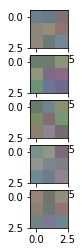

In [0]:
show_convs_firstlayer(deeplab, 0, 5)

## Find an optimal LR range
The idea is to train single epochs on a small subset of data, and see which range for LR give the maximum slope.

  0%|          | 0/12 [00:00<?, ?it/s]

lr : 1e-06 | train_loss: 0.0988176092505455


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 1.93069772888325e-06 | train_loss: 0.09835368394851685


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 3.7275937203149398e-06 | train_loss: 0.09835850447416306


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 7.196856730011519e-06 | train_loss: 0.09848363697528839


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 1.3894954943731373e-05 | train_loss: 0.08426138758659363


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 2.682695795279725e-05 | train_loss: 0.07721099257469177


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 5.179474679231209e-05 | train_loss: 0.06831740587949753


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 9.999999999999996e-05 | train_loss: 0.05447058007121086


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.00019306977288832496 | train_loss: 0.05749486759305


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.00037275937203149384 | train_loss: 0.06020985171198845


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0007196856730011517 | train_loss: 0.0612439401447773


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.001389495494373137 | train_loss: 0.06096866354346275


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.002682695795279724 | train_loss: 0.05333187058568001


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.005179474679231208 | train_loss: 0.07199868559837341


100%|██████████| 12/12 [00:18<00:00,  1.57s/it]


lr : 0.009999999999999993 | train_loss: 0.06471546739339828


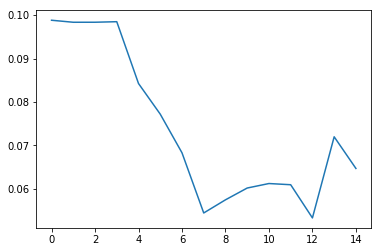

In [0]:
find_losses = []

low = 0.000001
high = 0.01
steps = 15
alpha = (high / low) ** (1 / (steps - 1))
# lrs = []

for step in range(steps):
    eta = low * (alpha ** step)
    train_loop_find(get_deeplab(1), 1, lr=eta)
    # lrs.append(eta)

# plt.plot(lrs)

plt.plot(find_losses)

## LR range : [1e-5 , 3e-3]

In [0]:
# deeplab = get_deeplab(1)

val_losses = []
train_losses = []
accuracies = []

# Train

### Warmup first

In [0]:
train_loop(deeplab, lr=0.00001, epochs=1)
train_loop(deeplab, lr=0.0001, epochs=1)
train_loop(deeplab, lr=0.001, epochs=1)

params_list.append(
    ('post warmup', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

filter #0: max: 0.18857550621032715 min: -0.17837396264076233
filter #1: max: 0.19250968098640442 min: -0.18000070750713348
filter #2: max: 0.19252337515354156 min: -0.18457621335983276
filter #3: max: 0.18860328197479248 min: -0.17164340615272522
filter #4: max: 0.1888134479522705 min: -0.18438808619976044


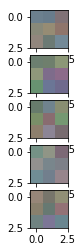

In [0]:
show_convs_firstlayer(deeplab, 1, 5)

In [0]:
train_loop(deeplab, lr=0.01, epochs=5)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint10")

params_list.append(
    ('first cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 2, 5)

100%|██████████| 50/50 [02:17<00:00,  2.77s/it]
150it [00:05, 26.90it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.3082299746076266 | accuracy: 0.5338070196906726 | train_loss: 0.18055196106433868


100%|██████████| 50/50 [02:16<00:00,  2.76s/it]
150it [00:05, 26.70it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.27055370680987834 | accuracy: 0.5279204481335668 | train_loss: 0.1710616797208786


100%|██████████| 50/50 [02:16<00:00,  2.75s/it]
150it [00:05, 39.77it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.2289338555186987 | accuracy: 0.5749227369204164 | train_loss: 0.1607448011636734


100%|██████████| 50/50 [02:16<00:00,  2.75s/it]
150it [00:05, 26.54it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.2527998873156806 | accuracy: 0.6102313511073589 | train_loss: 0.15627546608448029


100%|██████████| 50/50 [02:16<00:00,  2.74s/it]
150it [00:05, 27.25it/s]


val_loss: 0.22663632440691192 | accuracy: 0.5866537214761289 | train_loss: 0.15145644545555115


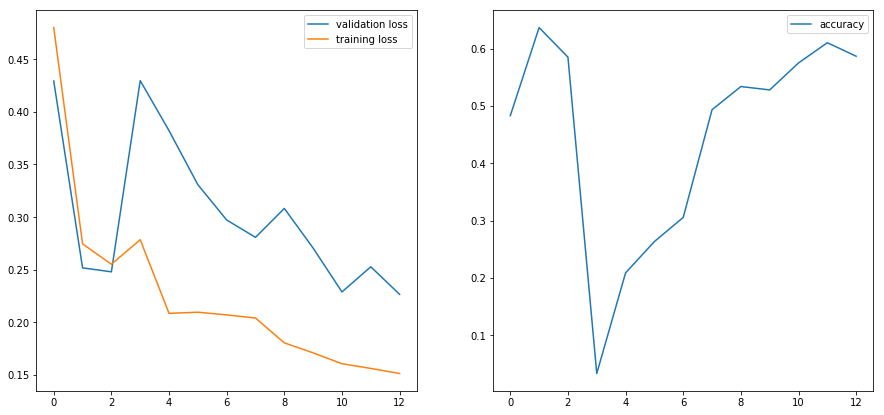

filter #0: max: 0.1618386209011078 min: -0.08241965621709824
filter #1: max: 0.14893396198749542 min: -0.027581162750720978
filter #2: max: 0.14952757954597473 min: -0.08986912667751312
filter #3: max: 0.08705773949623108 min: -0.02138533443212509
filter #4: max: 0.17010273039340973 min: -0.18944622576236725


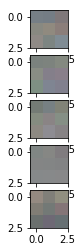

In [0]:
train_loop(deeplab, lr=0.005, epochs=5)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint11")

params_list.append(
    ('first cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 3, 5)

100%|██████████| 50/50 [02:16<00:00,  2.74s/it]
150it [00:05, 26.75it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.34058727086211243 | accuracy: 0.3703387736416577 | train_loss: 0.1644088327884674


100%|██████████| 50/50 [02:15<00:00,  2.73s/it]
150it [00:05, 26.81it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.36628930195855597 | accuracy: 0.4722152514134844 | train_loss: 0.15066692233085632


100%|██████████| 50/50 [02:14<00:00,  2.72s/it]
150it [00:05, 26.44it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.2900573630196353 | accuracy: 0.5658980426588096 | train_loss: 0.15374070405960083


100%|██████████| 50/50 [02:14<00:00,  2.71s/it]
150it [00:05, 27.33it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.23681844056894383 | accuracy: 0.6350645755258544 | train_loss: 0.1498815268278122


100%|██████████| 50/50 [02:14<00:00,  2.71s/it]
150it [00:05, 27.35it/s]


val_loss: 0.24388446300290526 | accuracy: 0.5990198234965404 | train_loss: 0.1485530585050583


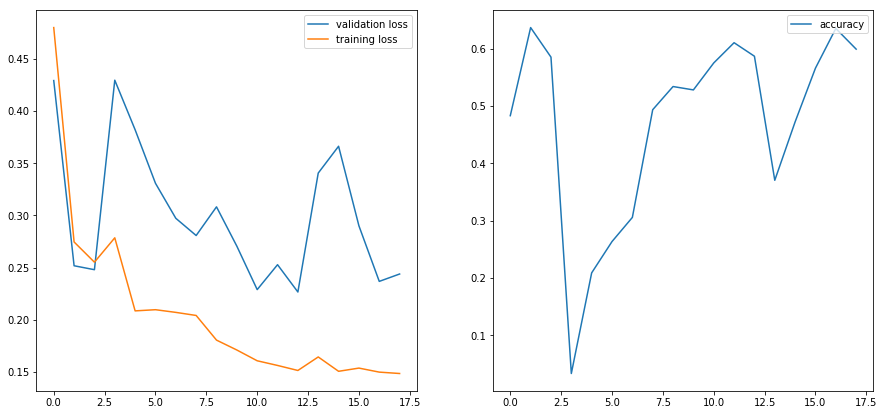

filter #0: max: 0.12034912407398224 min: -0.07659351825714111
filter #1: max: 0.1402912586927414 min: -0.013967461884021759
filter #2: max: 0.05596010014414787 min: -0.03963838517665863
filter #3: max: 0.11338172852993011 min: -0.013760034926235676
filter #4: max: 0.16448870301246643 min: -0.19545193016529083


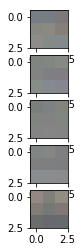

In [0]:
train_loop(deeplab, lr=0.008, epochs=5)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint12")

params_list.append(
    ('first cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 4, 5)

100%|██████████| 50/50 [02:15<00:00,  2.75s/it]
150it [00:05, 27.09it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.21831408188988766 | accuracy: 0.6346679039051135 | train_loss: 0.1457900106906891


100%|██████████| 50/50 [02:16<00:00,  2.73s/it]
150it [00:05, 39.87it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.2611020141125967 | accuracy: 0.5938589551734428 | train_loss: 0.14027893543243408


100%|██████████| 50/50 [02:15<00:00,  2.73s/it]
150it [00:05, 26.67it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.22606235859605173 | accuracy: 0.6299710119515658 | train_loss: 0.14165297150611877


100%|██████████| 50/50 [02:14<00:00,  2.71s/it]
150it [00:05, 27.22it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.2089014999071757 | accuracy: 0.6452791273392116 | train_loss: 0.13860629498958588


100%|██████████| 50/50 [02:13<00:00,  2.70s/it]
150it [00:05, 40.00it/s]


val_loss: 0.2302617352642119 | accuracy: 0.6200869033726243 | train_loss: 0.1347079873085022


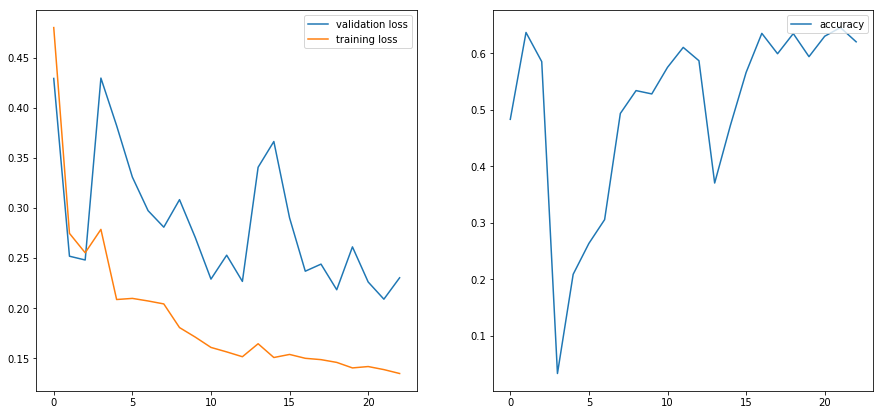

filter #0: max: 0.09597893059253693 min: -0.04975322261452675
filter #1: max: 0.13807198405265808 min: -0.006784061435610056
filter #2: max: 1.3698843304155162e-06 min: -1.7172289972222643e-06
filter #3: max: 0.07455694675445557 min: 0.033458128571510315
filter #4: max: 0.1150689348578453 min: -0.24922600388526917


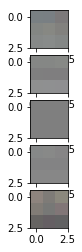

In [0]:
train_loop(deeplab, lr=0.005, epochs=5)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint12")

params_list.append(
    ('first cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 5, 5)

In [0]:
train_loop(deeplab, lr=0.004, epochs=3)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint13")

params_list.append(
    ('first cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 6, 5)

In [0]:
train_loop(deeplab, lr=0.001, epochs=5)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint14")

params_list.append(
    ('first cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 7, 5)

100%|██████████| 50/50 [02:16<00:00,  2.77s/it]
150it [00:05, 27.00it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.19063744792714715 | accuracy: 0.6840339541311066 | train_loss: 0.1170649603009224


100%|██████████| 50/50 [02:16<00:00,  2.76s/it]
150it [00:05, 26.50it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.1984766465735932 | accuracy: 0.6703514677612111 | train_loss: 0.11676571518182755


100%|██████████| 50/50 [02:15<00:00,  2.74s/it]
150it [00:05, 26.71it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.18209471330667534 | accuracy: 0.6845389634619157 | train_loss: 0.1174885556101799


100%|██████████| 50/50 [02:15<00:00,  2.73s/it]
150it [00:05, 39.12it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.19236780247340599 | accuracy: 0.6717089096425722 | train_loss: 0.11785389482975006


100%|██████████| 50/50 [02:14<00:00,  2.72s/it]
150it [00:05, 27.30it/s]


val_loss: 0.18334895002034804 | accuracy: 0.6889400042593479 | train_loss: 0.11651615798473358


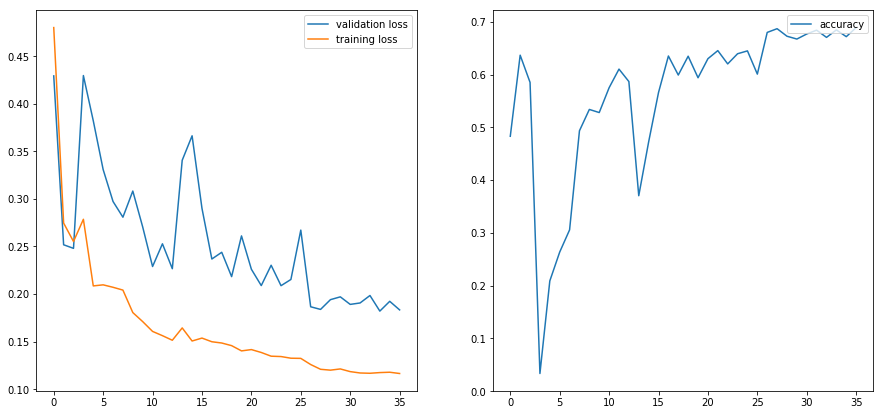

filter #0: max: 0.0002139203279512003 min: 2.537490763643291e-05
filter #1: max: 0.11029553413391113 min: -0.08692403137683868
filter #2: max: 0.0006862067384645343 min: -1.565637103340123e-05
filter #3: max: 0.009218581952154636 min: -0.002731593092903495
filter #4: max: 0.07401279360055923 min: -0.1476379781961441


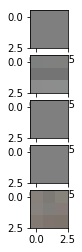

In [0]:
train_loop(deeplab, lr=0.0005, epochs=5)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint15")

params_list.append(
    ('seventh cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 8, 5)

100%|██████████| 50/50 [02:14<00:00,  2.73s/it]
150it [00:05, 26.91it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.19394149197886387 | accuracy: 0.6775240755205353 | train_loss: 0.11357608437538147


100%|██████████| 50/50 [02:15<00:00,  2.75s/it]
150it [00:05, 27.20it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.19087308842067918 | accuracy: 0.6817821557323138 | train_loss: 0.11278174817562103


100%|██████████| 50/50 [02:15<00:00,  2.74s/it]
150it [00:05, 26.73it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.19292480889707803 | accuracy: 0.6803707912688454 | train_loss: 0.1119907796382904


100%|██████████| 50/50 [02:15<00:00,  2.73s/it]
150it [00:05, 40.29it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.19311763669674595 | accuracy: 0.6779705396542947 | train_loss: 0.11362387984991074


100%|██████████| 50/50 [02:15<00:00,  2.75s/it]
150it [00:05, 27.28it/s]


val_loss: 0.18811773003078996 | accuracy: 0.6870401942326377 | train_loss: 0.11056465655565262


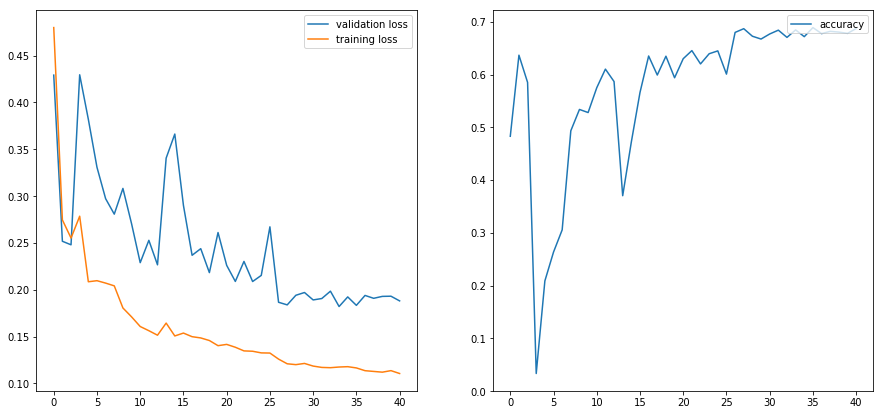

filter #0: max: 2.639385099367786e-10 min: -2.4564775213953283e-10
filter #1: max: 0.10681567341089249 min: -0.08992758393287659
filter #2: max: 6.541476693655568e-08 min: -1.681943651021811e-08
filter #3: max: 0.0025003827176988125 min: 0.0005987430340610445
filter #4: max: 0.07508216798305511 min: -0.14202973246574402


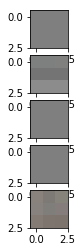

In [0]:
train_loop(deeplab, lr=0.0001, epochs=5)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint16")

params_list.append(
    ('eighth cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 9, 5)

In [0]:
def compare_convs_first_layer(num=7):
    plt.figure(figsize=(len(params_list)*1.5, num * 1.5))
    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    for i in range(num):
        for j in range(len(params_list)):
            plt.subplot(num, len(params_list), i * len(params_list) + j + 1)
            plt.imshow((params_list[j][1][0][i] + 0.5))

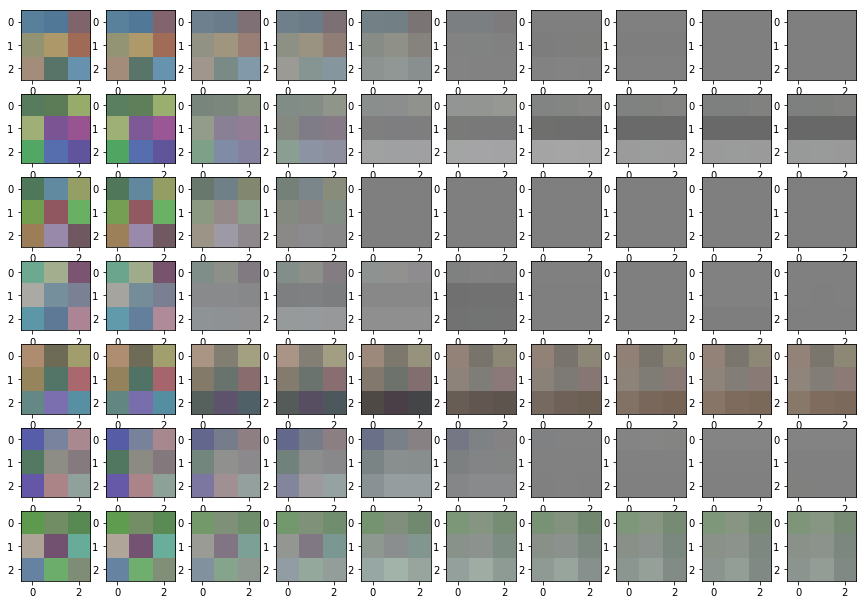

In [0]:
compare_convs_first_layer()

In [0]:
deeplab.load_state_dict(torch.load("/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint16"))

<All keys matched successfully>

## Some segmentation examples

In [0]:
def show_random_pairs(model, num_examples=3):
    plt.figure(figsize=(20, 5*num_examples))
    for i, idx in enumerate(np.random.permutation(len(val_img_x))[:num_examples]):
        print("val img x  min:{} max:{} mean:{}".format(val_img_x[idx].min(), val_img_x[idx].max(), val_img_x[idx].mean()))
        plt.subplot(num_examples, 3, 3*i + 1)
        plt.imshow(val_img_y[idx])
        plt.subplot(num_examples, 3, 3*i + 2)
        plt.imshow(val_img_x[idx].permute(1, 2, 0))
        plt.subplot(num_examples, 3, 3*i + 3)
        with torch.no_grad():
            preds = torch.sigmoid(model(val_img_x[idx].unsqueeze(0).to('cuda')))
            print("max: {} min: {}".format(preds.max(), preds.min()))
            print("mean: {} std: {}".format(preds.mean(), preds.std()))
            preds = preds > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'))

In [0]:
show_random_pairs(unet_2, 5)

In [0]:
show_random_pairs(unet_2, 3)

# Evaluate model on Test Set

In [0]:
def get_test_loss_accuracy_Dice(model, device='cuda'):
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in tqdm(zip(test_img_x, test_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = Dice_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

def get_test_loss_accuracy_IoU(model, device='cuda'):
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in tqdm(zip(test_img_x, test_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = IoU_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

In [0]:
t_loss, t_acc = get_test_loss_accuracy_Dice(deeplab)
print("\nLoss: {} | Accuracy (Dice): {}".format(t_loss, t_acc))


Loss: 0.2516615719511174 | Accuracy (Dice): 0.7706385996670967


In [0]:
t_loss, t_acc = get_test_loss_accuracy_IoU(deeplab)
print("\nLoss: {} | Accuracy (IoU): {}".format(t_loss, t_acc))

600it [00:15, 39.80it/s]


Loss: 0.2516615719511174 | Accuracy (IoU): 0.6780870831720434


## Test Accuracy
### (Dice Coefficient) = 77.8%
### (IoU) = 67.8%

## Sort Test data by loss

In [0]:
def get_sorted_loss_images(model, X, Y, device='cuda'):

    model.eval()

    idx_losses = []

    with torch.no_grad():
        for idx, (x, y) in tqdm(enumerate(zip(X, Y))):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)

            loss = bce_loss(preds, y.unsqueeze(0).to(device))
            
            idx_losses.append((loss.item(), idx))
    
    idx_losses.sort()

    return idx_losses

In [0]:
idx_loss_test = get_sorted_loss_images(deeplab, test_img_x, test_img_y)

600it [00:15, 39.54it/s]


## Show samples with most and those with least accuracy

In [0]:
def show_pairs_max(model, idx_losses, X, Y, num=10):
    plt.figure(figsize=(20, 5*num))
    for i, (loss, idx) in enumerate(list(reversed(idx_losses))):
        plt.subplot(num, 3, 3*i + 1)
        plt.imshow(Y[idx])
        plt.subplot(num, 3, 3*i + 2)
        plt.imshow(X[idx].permute(1, 2, 0))
        plt.subplot(num, 3, 3*i + 3)
        with torch.no_grad():
            preds = model(X[idx].unsqueeze(0).to('cuda')) > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'))

        if i >= num-1:
            break

def show_pairs_min(model, idx_losses, X, Y, num=10):
    plt.figure(figsize=(20, 5*num))
    for i, (loss, idx) in enumerate(idx_losses):
        plt.subplot(num, 3, 3*i + 1)
        plt.imshow(Y[idx], label='test')
        plt.subplot(num, 3, 3*i + 2)
        plt.imshow(X[idx].permute(1, 2, 0), label='Input Image')
        plt.subplot(num, 3, 3*i + 3)
        with torch.no_grad():
            preds = model(X[idx].unsqueeze(0).to('cuda')) > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'), label='model prediction')

        if i >= num-1:
            break

## Least Accurate predictions

(Dataset segmentation, image, model prediction)

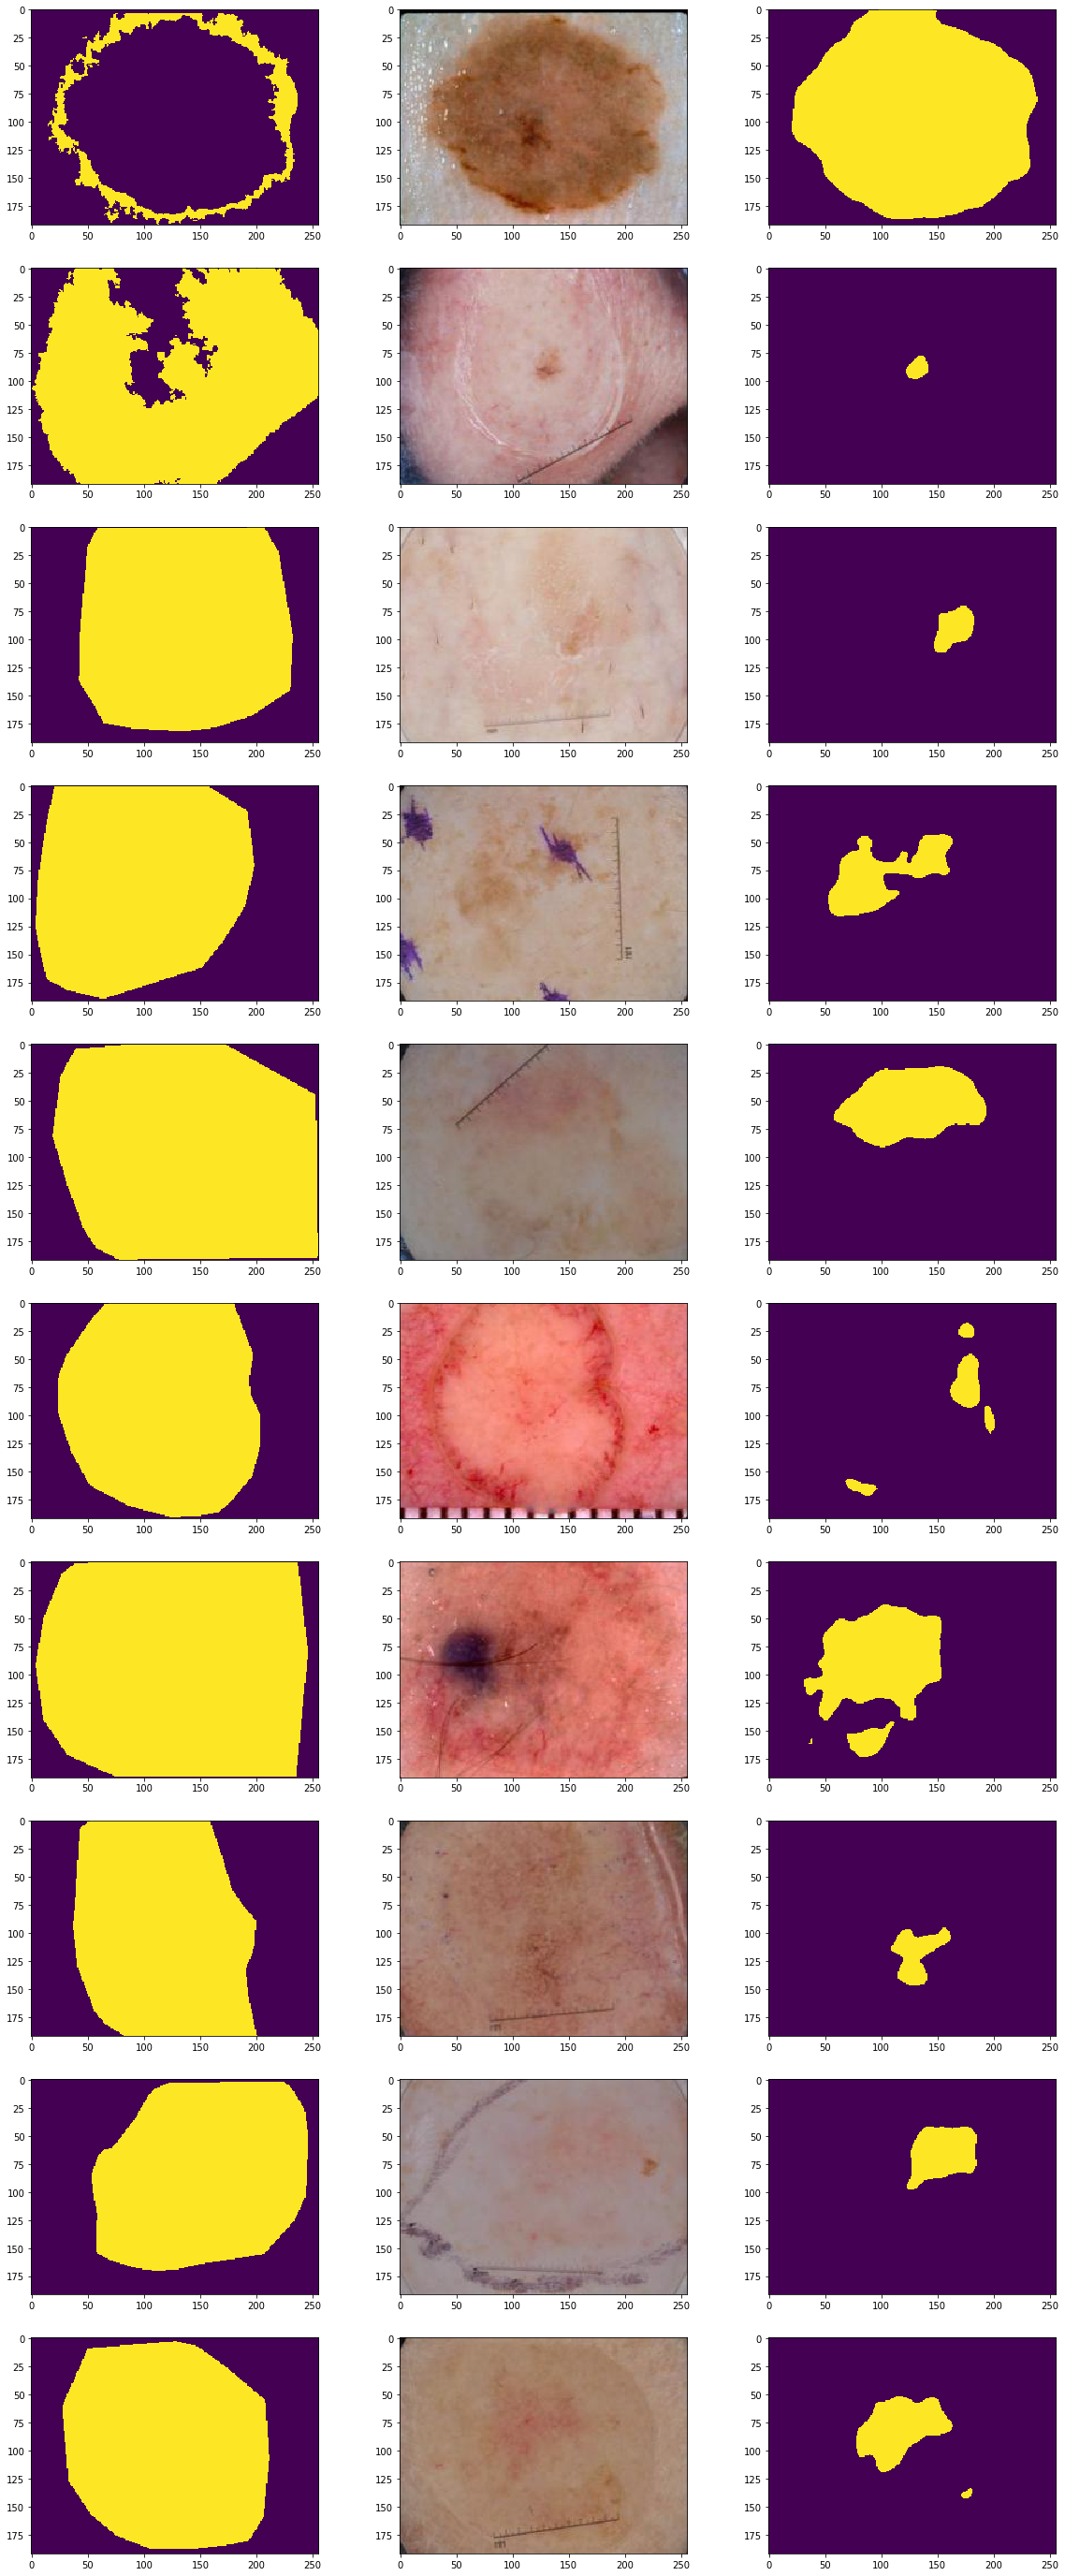

In [0]:
show_pairs_max(deeplab, idx_loss_test, test_img_x, test_img_y)

## Most Accurate Predictions

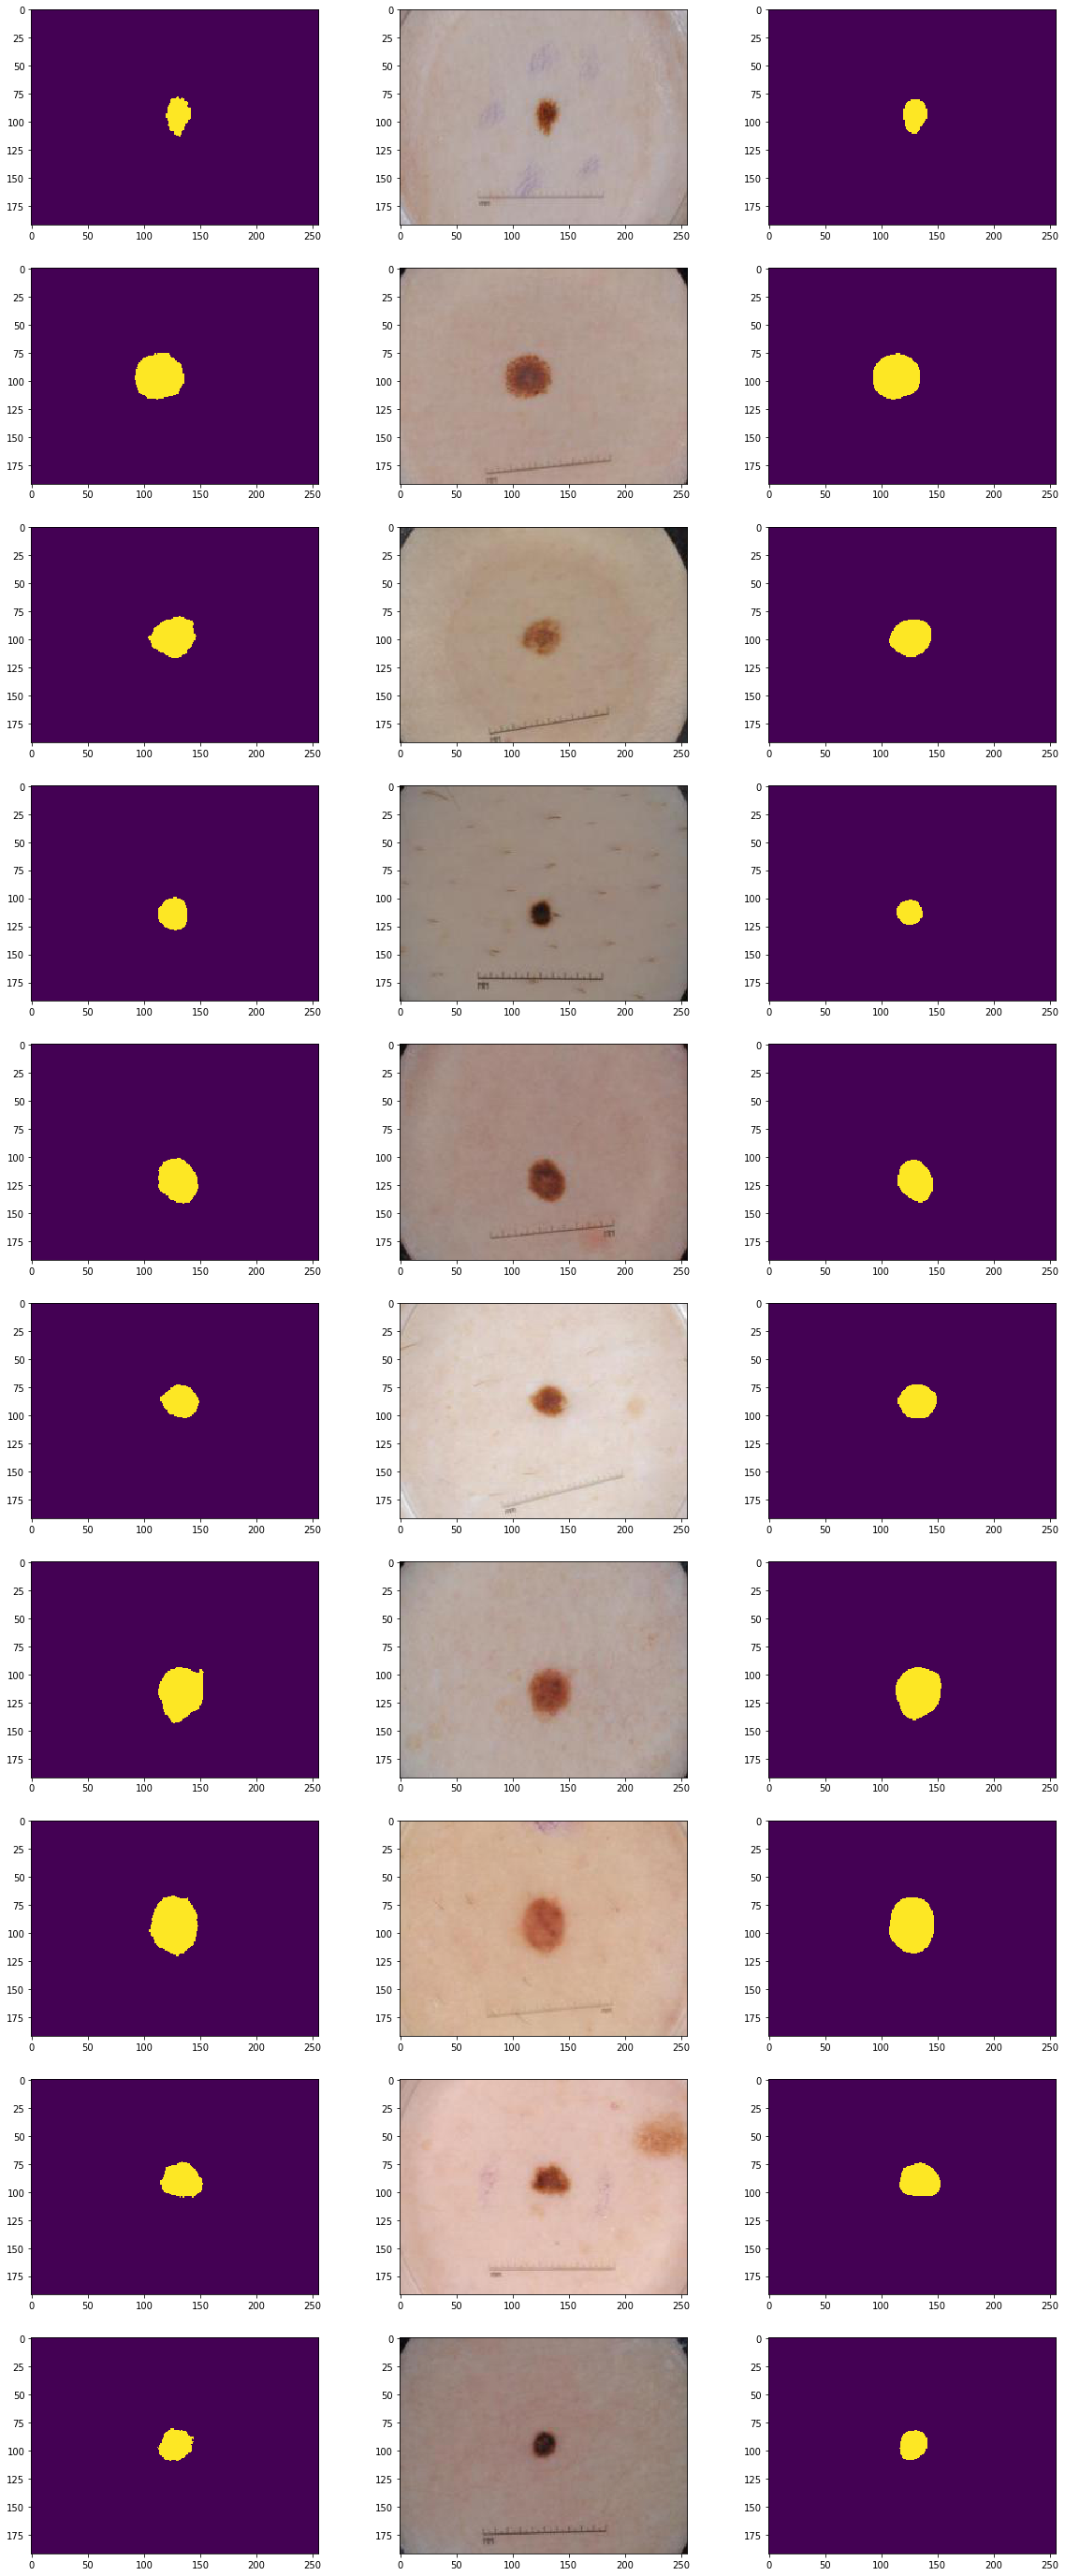

In [0]:
show_pairs_min(deeplab, idx_loss_test, test_img_x, test_img_y)

## Conclusion
The model seemed to have gotten stuck in a local minima, since decreasing the LR didn't change the loss or accuracy significantly after around 0.001

Also, the convolution filters seem to have mostly zeroed out, except a few which seem to be detecting edges. This might be a result of the high LR at the beginning.

Perhaps doing another run with a slightly lower initial LR, and running more epochs might improve performance

### Problems discovered in dataset
Some of the examples in the least accurate predictions seem to be really problems in the dataset. Our model's predictions seem to be actually reasonable.